# Исследование оттока клиентов телеком компании

#### Тема проекта:
- Прогнозирование ухода клиентов из телеком компании

#### Цель:
- Построить модель, предсказывающую уход клиента, со значением ROC-AUC не ниже 0.85

#### Поставленные задачи:
- Исследовать предоставленные данные;
- Подготовить данные для обучения;
- Рассмотреть несколько моделей;
- Выбрать модель с наилучшим значением ROC-AUC;
- Получить значение ROC-AUC не ниже 0.85.

#### Краткий план работы:
- [Шаг 1. Открытие и изучение файлов](#Шаг-1.-Открытие-и-изучение-файлов)
    - [Файл contract.csv](#Файл-contract.csv)
    - [Файл personal.csv](#Файл-personal.csv)
    - [Файл internet.csv](#Файл-internet.csv)
    - [Файл phone.csv](#Файл-phone.csv)
- [Шаг 2. Предобработка, исследовательский анализ и подготовка данных](#Шаг-2.-Предобработка,-исследовательский-анализ-и-подготовка-данных)
  - [2.1. Предобработка и исследовательский анализ](#2.1.-Предобработка-и-исследовательский-анализ)
  - [2.2. Подготовка данных для обучения](#2.2.-Подготовка-данных-для-обучения)
- [Шаг 3. Обучение и тестирование моделей](#Шаг-3.-Обучение-и-тестирование-моделей)
  - [3.1. Обучение моделей](#3.1.-Обучение-моделей)
    - [3.1.1. Логистическая регрессия](#3.1.1.-Логистическая-регрессия)
    - [3.1.2. Случайный лес](#3.1.2.-Случайный-лес)
    - [3.1.3. Градиентный бустинг (LightGBM)](#3.1.3.-Градиентный-бустинг-(LightGBM))
  - [3.2. Тестирование моделей](#3.2.-Тестирование-моделей)
- [Шаг 4. Сравнение моделей, выбор итоговой модели](#Шаг-4.-Сравнение-моделей,-выбор-итоговой-модели)
- [Шаг 5. Заключение (отчёт по решению)](#Шаг-5.-Заключение-(отчёт-по-решению))

#### Вывод:
- Исследованы предоставленные данные;
- Выбрана модель с наилучшими гиперпараметрами;
- На тестовой выборке удалось достигнуть значения ROC-AUC 0.90.

**Статус проекта**: проект завершён.

**Используемые библиотеки**: *numpy*, *pandas*, *matplotlib*, *seaborn*, *tqdm*, *sklearn*, *lightgbm*

**Источник данных**: [курс Data Science от Яндекс.Практикум](https://praktikum.yandex.ru/profile/data-scientist/)

In [1]:
# отключение предупреждений
import warnings
warnings.filterwarnings('ignore') 

# импорт библиотек и функций для дальнейшей работы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

## Шаг 1. Открытие и изучение файлов

Выгрузим файлы и посмотрим общую информацию по данным с помощью функции:

In [2]:
def read_info_open(file_path, date_col_list=False, verbose_dupl=True):    
    """Функция возвращает датафрейм и выводит наименования колонок, количество дубликатов, общую информацию:
    - file_path- путь к файлу .csv;
    - date_col_list - при наличии указать список колонок с датами (в кавычках);
    - verbose_dupl - вывод количества дубликатов и общей информации."""
    
    if date_col_list == False:
        new_df_name = pd.read_csv(file_path)
    else:
        new_df_name = pd.read_csv(file_path, parse_dates=date_col_list)

    if verbose_dupl:           
        print(new_df_name.columns) # проверка наименований колонок
        print()
        
        print('Количество дубликатов:', new_df_name.duplicated().sum()) # проверка на дубликаты
        print()
        
        print(new_df_name.info()) # общая информация
        
    return new_df_name

### Файл contract.csv

In [3]:
contract = read_info_open('final_datasets/contract.csv', ['BeginDate', 'EndDate'])
contract.head()

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


**Выгрузка contract.csv**:

- **Размер**
  - Таблица имеет **7043 строк** и **8 колонок**.
- **Пропуски**
  - На первый взгляд явных пропусков нет.
  - Формат колонки *EndDate* не был переведён в *datetime64*, поскольку в колонке содержится текстовое значение *No*. По сути, это **пропуск**, который имеет смысл.
- **Дубликаты**
  - Явных дубликатов не обнаружено.
  - Отдельно можно проверить колонку *customerID* на предмет наличия дублей.
  - Далее проверим отдельно значения текстовых колонок - возможно, будут обнаружены дубликаты.
- **Типы данных**
  - Обработать значение *No* и перевести в формат *datetime64* колонку *EndDate*.
  - Перевести *PaperlessBilling* в формат 0 и 1 в целях дальнейшего обучения.
  - Проверить, почему *TotalCharges* имеет формат *object*, а не *float*. Перевести колонку в правильный формат.
- **Имена колонок**
  - Лишних символов и пробелов не обнаружено. Теоретически можно было бы привести все названия к одному виду (написание с маленькой буквы и использование символа "_").

### Файл personal.csv

In [4]:
personal = read_info_open('final_datasets/personal.csv')
personal.head()

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Выгрузка personal.csv**:

- **Размер**
  - Таблица имеет **7043 строк** и **5 колонок**.
- **Пропуски**
  - На первый взгляд явных пропусков нет.
- **Дубликаты**
  - Явных дубликатов не обнаружено.
  - Отдельно проверим колонку *customerID*.
- **Типы данных**
  - Перевести *Partner*, *Dependents* в формат 0 и 1 в целях дальнейшего обучения.
- **Имена колонок**
  - Лишних символов и пробелов не обнаружено. Аналогичный комментарий относительно названия колонок. 
 
Для единообразия можем изменить название колонки *gender* на *Gender*:

In [5]:
personal.columns = ['customerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents']
personal.columns

Index(['customerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

### Файл internet.csv

In [6]:
internet = read_info_open('final_datasets/internet.csv')
internet.head()

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Выгрузка internet.csv**:

- **Размер**
  - Таблица имеет **5517 строк** и **8 колонок**.
- **Пропуски**
  - На первый взгляд явных пропусков нет.
- **Дубликаты**
  - Явных дубликатов не обнаружено.
  - Отдельно проверим колонку *customerID*.
- **Типы данных**
  - Перевести все колонки, кроме *customerID* и *InternetService* в формат 0 и 1 в целях дальнейшего обучения.
- **Имена колонок**
  - Лишних символов и пробелов не обнаружено. Аналогичный комментарий относительно названия колонок. 

### Файл phone.csv

In [7]:
phone = read_info_open('final_datasets/phone.csv')
phone.head()

Index(['customerID', 'MultipleLines'], dtype='object')

Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Выгрузка phone.csv**:

- **Размер**
  - Таблица имеет **6361 строк** и **2 колонки**.
- **Пропуски**
  - На первый взгляд явных пропусков нет.
- **Дубликаты**
  - Явных дубликатов не обнаружено.
  - Отдельно проверим колонку *customerID*.
- **Типы данных**
  - Рассмотреть значения *MultipleLines* и подумать над форматом.
- **Имена колонок**
  - Лишних символов и пробелов не обнаружено. Аналогичный комментарий относительно названия колонок. 

# Шаг 1. Вывод

- Мы ознакомились с полученными данными **4 таблиц**.
- Во всех случаях явных **дубликатов** не обнаружено. Во всех таблицах можно отдельно проверить *customerID* на наличие дубликатов.
- Не обнаружено неопознанных **пропусков** - все встретившиеся пропуски имеют **смысл**.
- Выделены проблемы с форматами некоторых колонок, например, *EndDate* и *TotalCharges*.
- Обнаружено несколько колонок со значениями *No* и *Yes*, которые имеет смысл перевести в формат 0 и 1 для дальнейшего обучения.

## Шаг 2. Предобработка, исследовательский анализ и подготовка данных

## 2.1. Предобработка и исследовательский анализ

Начнем с предобработки датафрейма *сontract*.

##### 1. Колонка customerID

В целом колонка не потребуется для обучения. Но можно проверить значения на наличие **дубликатов** и на соответствие **образцу**, чтобы в случае проблем предупредить об этом коллег.

In [8]:
def check_id_dupl(df_name):
    """Функция проверяет наличие дубликатов в колонке customerID."""
    
    # проверка на соответствие образцу
    pattern = '^\d{4}-\w{5}$' # 4 цифры - 5 букв
    print('Количество строк, соответствующих образцу:', end=' ')
    print(df_name['customerID'].str.contains(pattern).sum())
    
    # проверка наличия дубликатов
    return df_name[df_name['customerID'].duplicated()]

In [9]:
check_id_dupl(contract)

Количество строк, соответствующих образцу: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


- Дубликатов в колонке *customerID* не обнаружено.
- Все строки соответствуют единому образцу.

##### 2. Колонка BeginDate

Известно, что информация о договорах актуальна на 1 февраля 2020. Проверим, чтобы в колонке отсутствовали **аномальные даты**: слишком ранняя дата (например, 1990 год) или "даты из будущего" (например, 2022 год).

Первая дата заключения договора: 2013-10-01 00:00:00
Последняя дата заключения договора: 2020-02-01 00:00:00

2014-02-01    366
2019-11-01    237
2019-09-01    237
2019-10-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64


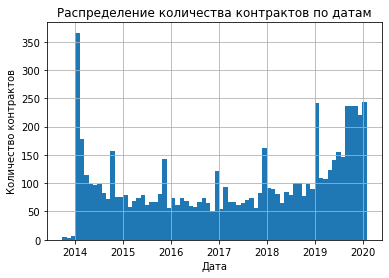

In [10]:
print('Первая дата заключения договора:', contract['BeginDate'].min())
print('Последняя дата заключения договора:', contract['BeginDate'].max())
print()
print(contract['BeginDate'].value_counts())

contract['BeginDate'].hist(bins=70)
plt.title('Распределение количества контрактов по датам')
plt.xlabel('Дата')
plt.ylabel('Количество контрактов')
plt.show()

- Аномально старые даты и даты из будущего **отсутствуют**. Самая ранняя дата 1 октября 2013, а самая поздняя - 1 февраля 2020. 
- Контракты заключались активно в начале **2014 года**. Также наблюдается большое количество в **конце 2019 года**.
- Возможно, прослеживается некоторая **сезональность**, но этот вопрос следует исследовать отдельно.

##### 3. Колонка EndDate

Выше мы обозначили проблему, что в колонке присутствуют текстовые значения.  
Значение *No* означает, что клиент продолжает пользоваться услугой.

In [11]:
print(contract['EndDate'].value_counts())
contract.head()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


- Из выборки 5174 клиентов продолжают пользоваться услугами.
- Есть только **4 даты окончания** использования услуг. На каждую дату приходится порядка **400 расторжений**.
- Судя по значениям, клиент **не может** расторгнуть услугу **в середине месяца**. 
- Показаны даты только за последние месяца - скорее всего, чтобы выявить **актуальную причину** ухода клиентов.

Изучив колонки с датами, сделаем следующее:
- Поскольку колонка *EndDate* содержит **целевой признак**, создадим на её основе колонку с **целевым признаком**, где 0 означает, что клиент не ушёл, а 1 - что ушёл.
- На основе этих колонок создадим признак **время жизни клиента** - рассчитаем, как долго клиент пользовался услугами компании.

In [12]:
# создание колонки с целевым признаком Exited: 0 - не ушёл, 1 - ушёл
contract['Exited'] = contract['EndDate']
contract['Exited'] = (contract['Exited'] != "No").astype('int')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Создадим колонку *CLifetime* с временем жизни клиента:

In [13]:
# замена No на последнюю актуальную дату
contract.loc[contract['EndDate'] == "No", 'EndDate'] = pd.to_datetime('2020-02-01')
contract['EndDate'] = pd.to_datetime(contract['EndDate'])
print(contract['EndDate'].value_counts())

# создание колонки
contract['CLifetime'] = contract['EndDate'] - contract['BeginDate']
contract.head()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61 days


In [14]:
# перевод days в float
contract['CLifetime'] = contract['CLifetime'] / np.timedelta64(1, 'D')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0,1036.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61.0


Для дальнейшей работы напишем **вспомогательные функции**:
- `count_churn` - для определения доли ушедших клиентов в колонке.
- `transform_binary` - для преобразования: значение *Yes* преобразуется в True 1, а *No* - в False 0.
- `sumstat_and_boxplot` - функция возвращает боксплот и сводную статистику по колонке с учётом разбивки по группам.
- `hist_by_groups` - функция возвращает две гистограммы по колонке с учётом разбивки по группам. 

In [15]:
def count_churn(df_name, col_name, col_count='Type'):
    """Функция выводит значения колонки и долю ушедших клиентов:
    - df_name - наименование датафрейма;
    - col_name - наименование колонки интереса;
    - col_count - вспомогательная колонка для подсчёта строк."""
    
    # доля по значениям
    print(df_name[col_name].value_counts(normalize=True))
    print()

    # группировка
    pivot_check = df_name.pivot_table(index=col_name, columns='Exited', aggfunc='count')[col_count]

    # вывод доли ушедших
    for i in range(len(pivot_check)):
        print(f'Доля ушедших (значение {pivot_check.index[i]}):', end=' ')
        print('{:.2%}'.format(pivot_check.iloc[i, 1] / pivot_check.iloc[i].sum()))  
    
    pivot_check['total'] = pivot_check[0] + pivot_check[1]
        
    return pivot_check

In [16]:
def transform_binary(df_name, col_name):    
    """Функция для преобразования: значение Yes преобразуется в True 1, а No - в False 0:
    - df_name - наименование датафрейма;
    - col_name - наименование колонки."""
    
    try:       
        # если значения колонке не соответствуют 'No', 'Yes', то будет выведена ошибка
        assert (np.sort(df_name[col_name].unique()) == ['No', 'Yes']).all()
        
        print('Значения ДО:')
        print(df_name[col_name].value_counts())
        print()
               
        # значение Yes преобразуется в True 1, а No - в False 0
        df_name[col_name] = (df_name[col_name] == "Yes").astype('int')        
        print('Значения ПОСЛЕ:')
        print(df_name[col_name].value_counts())

    except:       
        print('Проверьте значение в исходной колонке! Значения колонки не соответствуют "No" и "Yes"')

In [17]:
def sumstat_and_boxplot(df_name, col_name, group_by, box_title, box_ylabel, box_yticks=None):    
    """Функция возвращает боксплот и сводную статистику по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит группировка;
    - box_title - указать в именительном падеже название колонки;
    - box_ylabel - указать название оси y;
    - box_yticks (необязательный параметр) - задать диапазон для оси y"""
    
    boxplot = df_name.boxplot(col_name, by=group_by, figsize=(7, 5))
    plt.title(f'Сравнение по ушедшим и действующим клиентам ({box_title})')
    plt.xlabel('Тип клиента (0 - действующий, 1 - ушедший)')
    plt.ylabel(box_ylabel)
    plt.yticks(box_yticks)
    plt.show()
    
    sumstat = df_name.groupby(group_by)[col_name].describe()
    return sumstat

In [18]:
def hist_by_groups(df_name, col_name, group_by, box_title, box_xlabel, box_xticks=None, n_bins=30):   
    """Функция возвращает две гистограммы по колонке с учётом разбивки по группам.
    - df_name - название датафрейма;
    - col_name - рассматриваемая колонка;
    - group_by - колонка, по которой происходит группировка;
    - box_title - указать в именительном падеже название колонки;
    - box_xlabel - указать название оси x;
    - box_xticks (необязательный параметр) - задать диапазон для оси x;
    - n_bins (по умолчанию 30) - количество корзин."""
    
    # настройка размера
    plt.figure(figsize=(9,5))
    
    # построение гистограммы
    # на одном графике построим распределение данных
    sns.distplot(df_name[df_name[group_by] == 1][col_name], kde=True, label='ушедший', bins=n_bins)
    sns.distplot(df_name[df_name[group_by] == 0][col_name], kde=True, label='действующий', bins=n_bins)

    # линии среднего значения
    plt.axvline(x=df_name[df_name[group_by] == 1][col_name].mean(), color='blue', linestyle='--', label='ушедший (среднее)')
    plt.axvline(x=df_name[df_name[group_by] == 0][col_name].mean(), color='orange', linestyle='--', label='действующий (среднее)')

    plt.title('Распределение по ушедшим и действующим клиентам (' + box_title + ')')
    plt.xlabel(box_xlabel)
    plt.xticks(box_xticks, rotation=45)

    plt.legend()
    plt.grid()
    plt.show()

Применим написанные функции к колонке *CLifetime* и сравним группы по ушедшим и действующим клиентам.

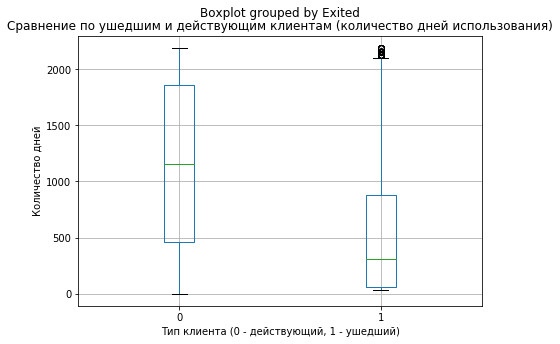

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,5174.0,1144.447236,733.897937,0.0,457.0,1157.0,1857.0,2191.0
1,1869.0,547.352060,594.389607,30.0,61.0,304.0,883.0,2191.0


In [19]:
# применение функции для построения boxplot
sumstat_and_boxplot(contract, 'CLifetime', 'Exited', 'количество дней использования', 'Количество дней')

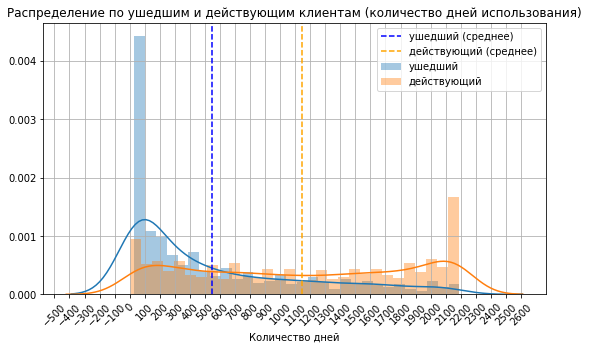

In [20]:
# применение функции для построения гистограмм
hist_by_groups(contract, 'CLifetime', 'Exited',
               'количество дней использования', 'Количество дней', np.arange(-500, 2601, 100), 30)

- Бóльшая часть выборочных **ушедших** клиентов пользовалась услугами **меньшее** количество времени, чем действующие клиенты.
- Например, половина **ушедших** выборочных клиентов пользовались услугами от 61 до 883 дней, в то время как для **действующих** клиентов этот показатель от 457 до 1857 дней.
- **Минимум** для **ушедших** клиентов равен **61 дням** использования. **Максимум** и **минимум** для ушедших и действующих клиентов одинаковый, т. е. среди **ушедших** клиентов также встречаются те, кто пользовался услугами достаточно продолжительное время.

##### 4. Type

Согласно условию, можно заключить контракт на 1 месяц, 1 год и 2 года. Проверим, что это так:

In [21]:
count_churn(contract, 'Type', 'PaperlessBilling')

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Type, dtype: float64

Доля ушедших (значение Month-to-month): 42.71%
Доля ушедших (значение One year): 11.27%
Доля ушедших (значение Two year): 2.83%


Exited,0,1,total
Type,,,
Month-to-month,2220,1655,3875
One year,1307,166,1473
Two year,1647,48,1695


- Всё корректно, присутствует только **3 значения**.
- В выборке большинство клиентов используют заключение контракта **на 1 месяц**.
- **Ушедшие** клиентов чаще пользовались **ежемесячным** *Month-to-month* способом оплаты. При этом **ниже** всего доля ушедших среди тех, кто платит сразу **за 2 года**.
- Поскольку проблем с регистром нет (из-за разного написания нет задублированных значений), то наименования можно оставить в текущем виде.

##### 5. PaperlessBilling

Колонка означает наличие "безбумажного" чека.  
Проверим, чтобы в колонке присутствовало только два значения *Yes* и *No*. Логичнее всего было бы перевести колонку в *boolean*. Но в целях дальнейшего обучения можем сразу привести данные **к значениям 0 и 1**.

In [22]:
count_churn(contract, 'PaperlessBilling')

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64

Доля ушедших (значение No): 16.33%
Доля ушедших (значение Yes): 33.57%


Exited,0,1,total
PaperlessBilling,,,
No,2403,469,2872
Yes,2771,1400,4171


- В колонке находилось только два значения *Yes* и *No*.
- Выборочная доля ушедших выше среди тех, кто пользовался электронным чеком.

Для дальнейшего обучения можем преобразовать значения колонки в **0 (False)** и **1 (True)**.

In [23]:
transform_binary(contract, 'PaperlessBilling')

Значения ДО:
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Значения ПОСЛЕ:
1    4171
0    2872
Name: PaperlessBilling, dtype: int64


##### 6. PaymentMethod

В колонке указан способ оплаты за услуги. Выведем значения и проверим регистр.

In [24]:
count_churn(contract, 'PaymentMethod')

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64

Доля ушедших (значение Bank transfer (automatic)): 16.71%
Доля ушедших (значение Credit card (automatic)): 15.24%
Доля ушедших (значение Electronic check): 45.29%
Доля ушедших (значение Mailed check): 19.11%


Exited,0,1,total
PaymentMethod,,,
Bank transfer (automatic),1286,258,1544
Credit card (automatic),1290,232,1522
Electronic check,1294,1071,2365
Mailed check,1304,308,1612


- Колонка содержит **4 способа** оплаты за связь: электронный и почтовый чек; автоматические банковский перевод и перевод по карте.
- Среди ушедших наибольшая доля приходится на клиентов, использовавших способ *Electronic check* - порядка 45%.
- Проблем из-за разного написания не выявлено.

##### 7. MonthlyCharges

Колонка означает сумму ежемесячной оплаты. Построим распределение данных и выведем сводную статистику.

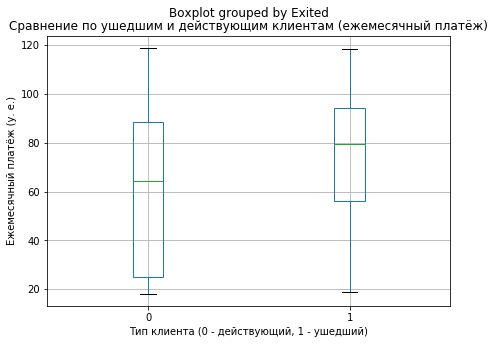

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
1,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


In [25]:
# применение функции для построения boxplot
sumstat_and_boxplot(contract, 'MonthlyCharges', 'Exited', 'ежемесячный платёж', 'Ежемесячный платёж (у. е.)')

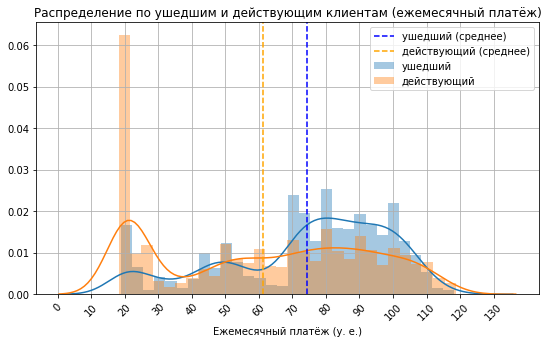

In [26]:
# применение функции для построения гистограмм
hist_by_groups(contract, 'MonthlyCharges', 'Exited',
               'ежемесячный платёж', 'Ежемесячный платёж (у. е.)', np.arange(0, 140, 10), 30)

- **Минимальная** ежемесячная сумма 18.25 у. е., **максимальная** - 118.75 y. e. (валюта неизвестна, поэтому будем использовать сокращение "условная единица"). Минимальные и максимальные суммы для клиентов двух типов довольно похожи.
- Распределение не симметрично и не унимодально. На гистограмме ярко выраженный **пик в районе 20 y. e.** Это особенно заметно для **действующих** выборочных клиентов.
- Около 25% **действующих** выборочных клиентов платят **до 25.1 у. е**. Для **ушедших** этот показатель - **до 56.2 у. е.**. 
- **Медиана** для ушедших клиентов также **больше**, чем для активных: **79.6 y. e.** против **64.4 у. е.**. Это же справедливо и для значений выборочного **среднего**.
- Из-за этого может сложиться первое впечатление, что ушедшие клиенты имели **более высокий** ежемесячный платёж, чем действующие клиенты.

##### 8. TotalCharges

На Шаге 1 мы столкнулись с тем, что колонка имеет тип *object*. Проверим, колонку на предмет наличия нечисленных значений.

In [27]:
# перевести значения колонки в numeric
check_val = contract[['TotalCharges']]
check_val['TotalCharges'] = pd.to_numeric(check_val['TotalCharges'], errors='coerce')

# в исходном датафрейме укажем индексы, в которых находились не численные значения
print('Количество строк с проблемными значениями:', len(contract.loc[check_val[check_val['TotalCharges'].isnull()].index, :]))
contract.loc[check_val[check_val['TotalCharges'].isnull()].index, :]

Количество строк с проблемными значениями: 11


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,,0,0.0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,,0,0.0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,,0,0.0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,,0,0.0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,,0,0.0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,,0,0.0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,,0,0.0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,,0,0.0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,,0,0.0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,,0,0.0


In [28]:
# проверка постороннего символа
contract.loc[488, 'TotalCharges']   

' '

- Проблема возникла из-за того, что в значениях вместо пропуска указан **пробел**.
- Всего в датафрейме **11 значений** с подобной проблемой.
- Все эти значения приходятся на **1 февраля 2020 года**. 

Выведем срез и проверим значение *TotalCharges* для всех строк с датой **1 февраля 2020 года**:

In [29]:
print('Количество строк:', len(contract[contract['BeginDate'] == '2020-02-01']))
contract[contract['BeginDate'] == '2020-02-01']

Количество строк: 11


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,,0,0.0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,,0,0.0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,,0,0.0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,,0,0.0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,,0,0.0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,,0,0.0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,,0,0.0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,,0,0.0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,,0,0.0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,,0,0.0


Строки те же самые, значит, **пропуски** на самом деле имеют **смысл**: данные актуальны по **01.02.2020**. Клиент только заключил договор, поэтому сложно что-то сказать по финальной стоимость услуг.

Заменим пробелы на **ноль** (клиент ещё ничего не заплатил):

In [30]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
print(contract.info())
contract[contract['BeginDate'] == '2020-02-01'].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int32         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Exited            7043 non-null   int32         
 9   CLifetime         7043 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int32(2), object(3)
memory usage: 495.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,0.0,0,0.0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,0.0,0,0.0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,0.0,0,0.0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,0.0,0,0.0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,0.0,0,0.0


Построим графики для *TotalCharges* по ушедшим и действующим клиентам.

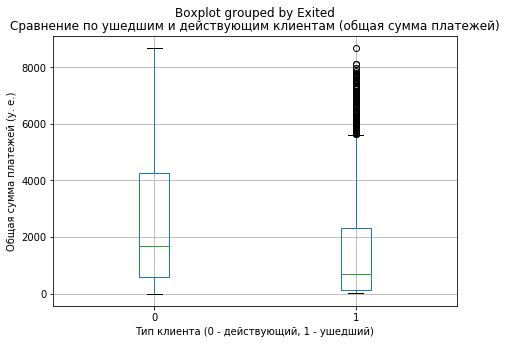

,count,mean,std,min,25%,50%,75%,max
Exited,,,,,,,,
0,5174.0,2549.911442,2329.954215,0.00,572.9,1679.525,4262.85,8672.45
1,1869.0,1531.796094,1890.822994,18.85,134.5,703.550,2331.30,8684.80


In [31]:
# применение функции для построения boxplot
sumstat_and_boxplot(contract, 'TotalCharges', 'Exited', 'общая сумма платежей', 'Общая сумма платежей (у. е.)')

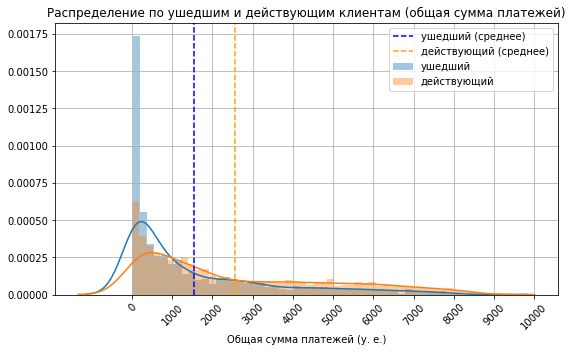

In [32]:
# применение функции для построения гистограмм
hist_by_groups(contract, 'TotalCharges', 'Exited',
               'общая сумма платежей', 'Общая сумма платежей (у. е.)', np.arange(0, 10**4+1, 1000), 50)

- Распределение больше напоминает напоминает по форме распределение **Пуассона**, наблюдается явная скошенность данных в сторону бóльших значений.
- **Минимальное** значение равно **18.8 у. е.**, а **максимальное** - **8684.8 у. е.** Минимальные и максимальные значения для обеих групп достаточно похожи.
- **Среднее** и **медиана** для действующих клиентов выше, чем для ушедших. Это согласуется с тем, что мы видели ранее - ушедшие клиенты пользовались услугами **меньшее** количество времени. Соответственно, общий платеж тоже получился **меньше**.
- Для **ушедших** клиентов наблюдается более ярко выраженный **пик** около **минимальных** значений, чем для действующих.

Для дальнейшей работы нам понадобятся признаки из **нескольких таблиц**. Поскольку все эти данные относятся к одной выборке, можем сразу **объединить** таблицы в одну. Такое объединение также поможет нам сравнивать признаки таблиц по двум группам.

Для начала проверим, что:
- В таблицах с общей информацией *contract* и *personal* содержатся **одни и те же id**.
- Id в таблицах по интернету и телефонных звонках присутствуют в таблицах *contract* и *personal*.

Сначала проверим инедтичность id в *contract* и *personal*:

In [33]:
# проверка идентичности ID
print('ID идентичны в обоих датафреймах:', end=' ')
print((np.sort(contract['customerID']) == np.sort(personal['customerID'])).all())

# проверка написания и дубликатов
check_id_dupl(personal)

ID идентичны в обоих датафреймах: True
Количество строк, соответствующих образцу: 7043


,customerID,Gender,SeniorCitizen,Partner,Dependents


Теперь проверим, чтобы id других таблиц присутствовали в *contract* и *personal*:

In [34]:
# проверка internet
print('В датафрейме отсутствуют посторонние id:', end=' ')
print(internet['customerID'].isin(personal['customerID']).all())

# проверка написания и дубликатов
check_id_dupl(internet)

В датафрейме отсутствуют посторонние id: True
Количество строк, соответствующих образцу: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


In [35]:
# проверка phone
print('В датафрейме отсутствуют посторонние id:', end=' ')
print(phone['customerID'].isin(personal['customerID']).all())

# проверка написания и дубликатов
check_id_dupl(phone)

В датафрейме отсутствуют посторонние id: True
Количество строк, соответствующих образцу: 6361


,customerID,MultipleLines


Проверка id осуществлена, проблем не обнаружено. Теперь сделаем соединение по индексу, установив в качестве индекса *customerID*.

In [36]:
# установка в качестве индекса customerID
for df in [contract, personal, internet, phone]:
    df.set_index('customerID', inplace=True)

# проверка последнего датафрейма
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [37]:
# соединение датафреймов в один
telecom = pd.concat([contract, personal, internet, phone], axis=1, join='outer')
print(telecom.info())

telecom.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int32         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Exited            7043 non-null   int32         
 8   CLifetime         7043 non-null   float64       
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2351-RRBUE,2019-07-01,2020-02-01,One year,0,Mailed check,20.65,134.05,0,215.0,Female,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4825-XJGDM,2015-01-01,2020-02-01,One year,0,Credit card (automatic),43.70,2696.55,0,1857.0,Female,...,No,No,DSL,Yes,Yes,Yes,Yes,No,No,NaN
7861-UVUFT,2018-10-01,2020-01-01,Month-to-month,1,Electronic check,84.30,1308.40,1,457.0,Female,...,Yes,No,Fiber optic,No,No,Yes,No,Yes,No,No
6463-HHXJR,2014-03-01,2020-02-01,Two year,0,Bank transfer (automatic),100.50,7030.65,0,2163.0,Female,...,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Yes
0887-WBJVH,2015-09-01,2020-02-01,One year,1,Electronic check,93.45,4872.20,0,1614.0,Female,...,Yes,No,Fiber optic,No,No,No,Yes,Yes,Yes,No


##### 9. Колонка Gender

Проверим, чтобы в колонке пола присутствовало только два значения:

In [38]:
count_churn(telecom, 'Gender')

Male      0.504756
Female    0.495244
Name: Gender, dtype: float64

Доля ушедших (значение Female): 26.92%
Доля ушедших (значение Male): 26.16%


Exited,0,1,total
Gender,,,
Female,2549,939,3488
Male,2625,930,3555


- В выборке примерно одинаковое число мужчин и женщин.
- Для мужчин и женщин одинаковая доля среди **ушедших** клиентов.

##### 10. Колонка SeniorCitizen

Данная колонка означает, является ли человек пенсионером. Также проверим, чтобы в выборке было только 2 значения.

In [39]:
count_churn(telecom, 'SeniorCitizen')

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

Доля ушедших (значение 0): 23.61%
Доля ушедших (значение 1): 41.68%


Exited,0,1,total
SeniorCitizen,,,
0,4508,1393,5901
1,666,476,1142


- Всё корректно, присутствует только два значения 0 и 1.
- В выборке большинство клиентов является **не пенсионерами**.
- При этом среди **пенсионеров** довольно высокая доля ушедших клиентов.

##### 11, 12. Колонка Partner, Dependents

Колонка *Partner* означает, есть ли у человека партнёр. Иными словами, это **семейное положение** клиента.  
Колонка *Dependents* означает, имеет ли клиент **иждивенцев**. Под термином "иждивенец" в данном случае подразумеваются дети.

Проверим, чтобы в колонке присутствовало только 2 значения. Если всё в порядке, переведём значения в 0 и 1.

In [40]:
count_churn(telecom, 'Partner')

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

Доля ушедших (значение No): 32.96%
Доля ушедших (значение Yes): 19.66%


Exited,0,1,total
Partner,,,
No,2441,1200,3641
Yes,2733,669,3402


- В выборке клиенты имеющие и не имеющие партнёров распределились примерно **поровну**.
- Доля ушедших выше среди тех, кто **не имеет** партнёра.

In [41]:
count_churn(telecom, 'Dependents')

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

Доля ушедших (значение No): 31.28%
Доля ушедших (значение Yes): 15.45%


Exited,0,1,total
Dependents,,,
No,3390,1543,4933
Yes,1784,326,2110


- Большая часть клиентов выборки **не имеет** иждивенцев.
- Доля **ушедших** выше среди тех, кто **не имеет** иждивенцев.

Преобразуем значения этих колонок в 0 и 1.

In [42]:
for col in ['Dependents', 'Partner']:
    print('Обработка колонки {}'.format(col))
    transform_binary(telecom, col)
    print()

Обработка колонки Dependents
Значения ДО:
No     4933
Yes    2110
Name: Dependents, dtype: int64

Значения ПОСЛЕ:
0    4933
1    2110
Name: Dependents, dtype: int64

Обработка колонки Partner
Значения ДО:
No     3641
Yes    3402
Name: Partner, dtype: int64

Значения ПОСЛЕ:
0    3641
1    3402
Name: Partner, dtype: int64



Перейдём к колонкам, которые относятся к информации об **интернет-услугах**.  
Поскольку не все клиенты пользуются этой услугой, то для некоторых клиентов ожидается наличие **пропусков**.

##### 13. InternetService

Проверим, чтобы в датафрейме было **только 2 опции**, указанные в задании: подключение через телефонную линию или оптиковолоконный кабель.  
Рассмотрим только тех клиентов, кто **пользуется** услугами.

In [43]:
count_churn(telecom, 'InternetService')

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

Доля ушедших (значение DSL): 18.96%
Доля ушедших (значение Fiber optic): 41.89%


Exited,0,1,total
InternetService,,,
DSL,1962,459,2421
Fiber optic,1799,1297,3096


- В выборке несколько больше пользователей, использующих подключение через **оптиковолоконный кабель**.
- Но при этом доля **ушедших** клиентов заметно больше для пользователей *Fiber optic*. Это может натолкнуть на мысль, что с данным типом покдлючения могут быть какие-то **проблемы**.

In [44]:
telecom['InternetService'].value_counts(dropna=False)

Fiber optic    3096
DSL            2421
NaN            1526
Name: InternetService, dtype: int64

В колонке присутствуют **пропуски** они появились после соединения таблиц.  
**Пропуск** означает, что клиент в принципе не пользуется данной услугой. Чтобы во время обучения разграничивать таких клиентов, заменим пропуск словом "No". Так будет ясно, что у клиента нет интернета.

In [45]:
# замена пропуска в InternetService
telecom['InternetService'].fillna('No', inplace=True)
print(telecom['InternetService'].value_counts(dropna=False))

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


##### 14-19. OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies

Все эти колонки обозначают подключена дополнительная услуга или нет.  
Поскольку не все используют интернет-услуги, то в некоторых строках будут **пропуски**.  
Можем сразу заменить пропуски на "No" (т. е. клиент не пользуется услугой). Затем по аналогии с предыдущими случаями преобразуем значения всех колонок в 0 и 1. 

In [46]:
# замена пропусков на No
for col in telecom.columns[14:-1]:
    telecom[col].fillna("No", inplace=True)

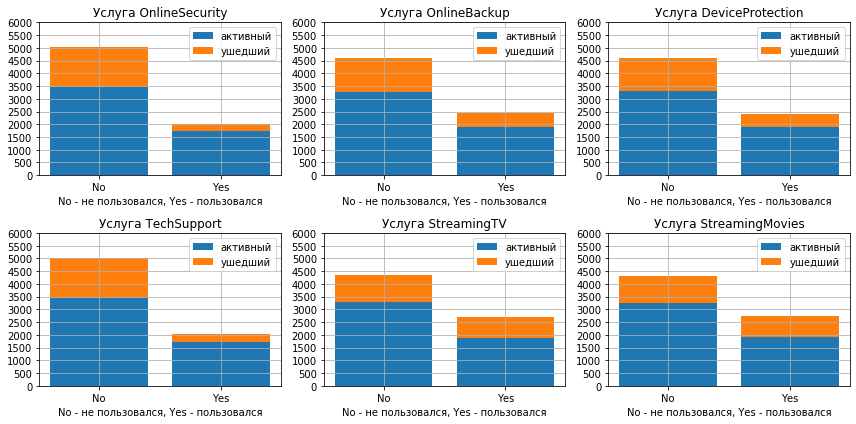

In [47]:
# вывод графиков по колонкам с услугами
fig = plt.figure(figsize=(12, 6))

x = ['No', 'Yes']
for i, col in enumerate(telecom.columns[14:-1]):
    
    fig.add_subplot(2, 3, i+1)   
    
    pivot_tab = telecom.pivot_table(index=col, columns='Exited', aggfunc='count')['BeginDate']
    y_no = pivot_tab.iloc[:, 0]
    y_yes = pivot_tab.iloc[:, 1]
    
    plt.bar(x, y_no, label="активный")
    plt.bar(x, y_yes, label="ушедший", bottom=y_no)    
    plt.legend()
    
    plt.title(f'Услуга {col}')
    plt.xlabel('No - не пользовался, Yes - пользовался')
    plt.xticks(rotation=360)
    plt.yticks(np.arange(0, 6001, 500))
    plt.grid()
    plt.tight_layout() 

In [48]:
for col in telecom.columns[14:-1]:
    tab = count_churn(telecom, col)
    print()
    print(tab)
    print('--------------------------------------')
    print()

No     0.713332
Yes    0.286668
Name: OnlineSecurity, dtype: float64

Доля ушедших (значение No): 31.33%
Доля ушедших (значение Yes): 14.61%

Exited             0     1  total
OnlineSecurity                   
No              3450  1574   5024
Yes             1724   295   2019
--------------------------------------

No     0.655119
Yes    0.344881
Name: OnlineBackup, dtype: float64

Доля ушедших (значение No): 29.17%
Доля ушедших (значение Yes): 21.53%

Exited           0     1  total
OnlineBackup                   
No            3268  1346   4614
Yes           1906   523   2429
--------------------------------------

No     0.656112
Yes    0.343888
Name: DeviceProtection, dtype: float64

Доля ушедших (значение No): 28.65%
Доля ушедших (значение Yes): 22.50%

Exited               0     1  total
DeviceProtection                   
No                3297  1324   4621
Yes               1877   545   2422
--------------------------------------

No     0.709783
Yes    0.290217
Name: TechSupp

- **Наиболее популярные** услуги среди выборочных пользователей: стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).
- **Наименее популярные** услуги - блокировка небезопасных сайтов (*OnlineSecurity*) и выделенная линия технической поддержки (*TechSupport*).
- Довольно высокая доля пользователей среди **ушедших** клиентов для тех, кто:
  - **Пользовался** сервисами *StreamingTV* и *StreamingMovies*.
  - **Не пользовался** сервисами *OnlineSecurity* и *TechSupport*.
  
В целях дальнейшего обучения преобразуем все значения в 0 и 1:

In [49]:
# преобразование в 0 и 1
for col in telecom.columns[14:-1]:
    print('Обработка колонки {}'.format(col))
    transform_binary(telecom, col)
    print()

Обработка колонки OnlineSecurity
Значения ДО:
No     5024
Yes    2019
Name: OnlineSecurity, dtype: int64

Значения ПОСЛЕ:
0    5024
1    2019
Name: OnlineSecurity, dtype: int64

Обработка колонки OnlineBackup
Значения ДО:
No     4614
Yes    2429
Name: OnlineBackup, dtype: int64

Значения ПОСЛЕ:
0    4614
1    2429
Name: OnlineBackup, dtype: int64

Обработка колонки DeviceProtection
Значения ДО:
No     4621
Yes    2422
Name: DeviceProtection, dtype: int64

Значения ПОСЛЕ:
0    4621
1    2422
Name: DeviceProtection, dtype: int64

Обработка колонки TechSupport
Значения ДО:
No     4999
Yes    2044
Name: TechSupport, dtype: int64

Значения ПОСЛЕ:
0    4999
1    2044
Name: TechSupport, dtype: int64

Обработка колонки StreamingTV
Значения ДО:
No     4336
Yes    2707
Name: StreamingTV, dtype: int64

Значения ПОСЛЕ:
0    4336
1    2707
Name: StreamingTV, dtype: int64

Обработка колонки StreamingMovies
Значения ДО:
No     4311
Yes    2732
Name: StreamingMovies, dtype: int64

Значения ПОСЛЕ:
0   

##### 20. Колонка MultipleLines

Колонка означает, подключён ли телефон к нескольким линиям одновременно.  
Сначала рассмотрим данные по клиентам, когда-либо подключавшим данную услугу.

In [50]:
count_churn(telecom, 'MultipleLines')

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

Доля ушедших (значение No): 25.04%
Доля ушедших (значение Yes): 28.61%


Exited,0,1,total
MultipleLines,,,
No,2541,849,3390
Yes,2121,850,2971


- В выборке **примерно одинаковое** количество с подключениями к одной и нескольким линиям.
- На первый взгляд доля ушедших и действующих клиентов тоже примерно одинаковая.

Напомним, что в колонке появились **пропуски**. **Пропуск** означает, что клиент в принципе не пользуется данной услугой.  

Если мы поставим в *MultipleLines* 0 вместо пропуска, это может внести **путаницу**. Так как мы не сможем понять, что конкретно он обозначает - у клиента отсутствует подключение на несколько линий или в принципе не подключен телефон?

Чтобы во время обучения разграничивать таких клиентов, можно заменить значения на категории, где пропуск будет заменён на *No* - нет телефона.

In [51]:
print(telecom['MultipleLines'].value_counts(dropna=False))
print()

telecom.loc[telecom['MultipleLines'] == "No", 'MultipleLines'] = 'line_1'
telecom.loc[telecom['MultipleLines'] == "Yes", 'MultipleLines'] = 'line_many'
telecom['MultipleLines'].fillna('No', inplace=True)

No     3390
Yes    2971
NaN     682
Name: MultipleLines, dtype: int64



In [52]:
print(telecom['MultipleLines'].value_counts(dropna=False))
telecom.sample(5)

line_1       3390
line_many    2971
No            682
Name: MultipleLines, dtype: int64


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0575-CUQOV,2015-02-01,2020-02-01,One year,1,Electronic check,97.95,5867.00,0,1826.0,Male,...,1,0,Fiber optic,0,1,1,0,1,1,line_1
9061-TIHDA,2018-11-01,2019-12-01,Month-to-month,1,Electronic check,95.25,1233.65,1,395.0,Male,...,1,0,Fiber optic,0,0,0,0,1,1,line_many
8788-DOXSU,2015-03-01,2020-02-01,One year,1,Bank transfer (automatic),61.35,3645.50,0,1798.0,Male,...,0,0,DSL,0,0,1,0,0,1,line_1
6873-UDNLD,2016-10-01,2020-02-01,Month-to-month,0,Electronic check,67.45,2731.00,0,1218.0,Male,...,0,0,DSL,1,0,1,0,0,1,line_1
2262-SLNVK,2020-01-01,2020-02-01,Month-to-month,0,Electronic check,70.10,70.10,0,31.0,Female,...,0,0,Fiber optic,0,0,0,0,0,0,line_1


В качестве финального шага:
- **Удалим** колонки с **датами**, которые могут спровоцировать утечку целевого признака.
- Сделаем **сброк** индексов с id, т. к. они не понадобятся для дальнейшей работы.

In [53]:
telecom.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)
telecom.reset_index(drop=True, inplace=True)
telecom.head(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,CLifetime,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,1,Electronic check,29.85,29.85,0,31.0,Female,0,1,0,DSL,0,1,0,0,0,0,No
1,One year,0,Mailed check,56.95,1889.50,0,1036.0,Male,0,0,0,DSL,1,0,1,0,0,0,line_1
2,Month-to-month,1,Mailed check,53.85,108.15,1,61.0,Male,0,0,0,DSL,1,1,0,0,0,0,line_1
3,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371.0,Male,0,0,0,DSL,1,0,1,1,0,0,No
4,Month-to-month,1,Electronic check,70.70,151.65,1,61.0,Female,0,0,0,Fiber optic,0,0,0,0,0,0,line_1
5,Month-to-month,1,Electronic check,99.65,820.50,1,245.0,Female,0,0,0,Fiber optic,0,0,1,0,1,1,line_many
6,Month-to-month,1,Credit card (automatic),89.10,1949.40,0,671.0,Male,0,0,1,Fiber optic,0,1,0,0,1,0,line_many
7,Month-to-month,0,Mailed check,29.75,301.90,0,306.0,Female,0,0,0,DSL,1,0,0,0,0,0,No
8,Month-to-month,1,Electronic check,104.80,3046.05,1,853.0,Female,0,1,0,Fiber optic,0,0,1,1,1,1,line_many
9,One year,0,Bank transfer (automatic),56.15,3487.95,0,1888.0,Male,0,0,1,DSL,1,1,0,0,0,0,line_1


### Проверка данных на мультиколлинеарность

In [54]:
# дейсвующие клиенты
# матрица с корреляциями
not_exited_matrix = (telecom[['MonthlyCharges', 'TotalCharges', 'CLifetime', 'Exited']]
                     .query('Exited == 0').drop(['Exited'], axis=1))
not_exited_matrix.corr()

,MonthlyCharges,TotalCharges,CLifetime
MonthlyCharges,1.000000,0.756874,0.330878
TotalCharges,0.756874,1.000000,0.793714
CLifetime,0.330878,0.793714,1.000000


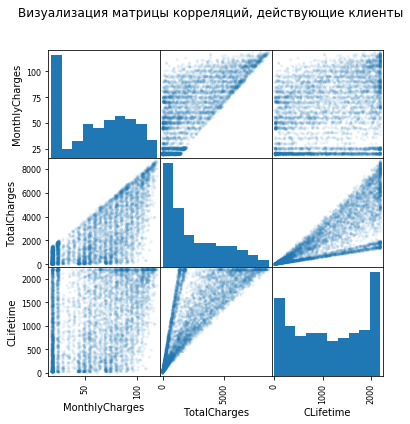

In [55]:
_ = pd.plotting.scatter_matrix(not_exited_matrix, figsize=[6, 6], alpha=0.1)
plt.suptitle('Визуализация матрицы корреляций, действующие клиенты')
plt.show()

In [56]:
# ушедшие клиенты
# матрица с корреляциями
exited_matrix = (telecom[['MonthlyCharges', 'TotalCharges', 'CLifetime', 'Exited']]
                 .query('Exited == 1').drop(['Exited'], axis=1))
exited_matrix.corr()

,MonthlyCharges,TotalCharges,CLifetime
MonthlyCharges,1.000000,0.545772,0.401331
TotalCharges,0.545772,1.000000,0.954027
CLifetime,0.401331,0.954027,1.000000


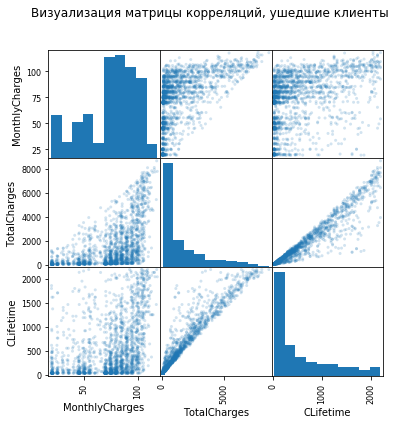

In [57]:
_ = pd.plotting.scatter_matrix(exited_matrix, figsize=[6, 6], alpha=0.2)
plt.suptitle('Визуализация матрицы корреляций, ушедшие клиенты')
plt.show()

In [58]:
# все клиенты
# матрица с корреляциями
telecom[['MonthlyCharges', 'TotalCharges', 'CLifetime']].corr()

,MonthlyCharges,TotalCharges,CLifetime
MonthlyCharges,1.000000,0.651174,0.247754
TotalCharges,0.651174,1.000000,0.826109
CLifetime,0.247754,0.826109,1.000000


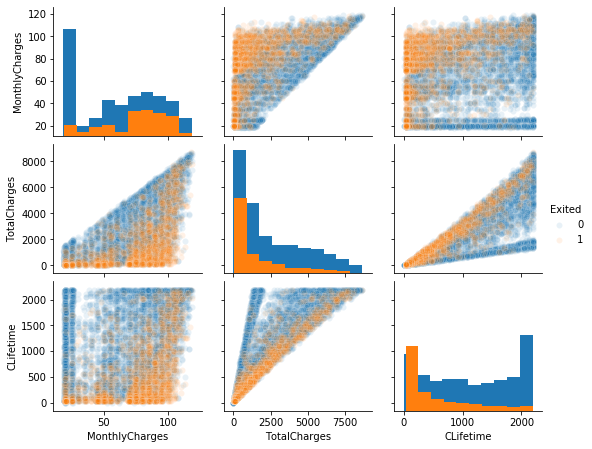

In [59]:
# визуализация матрицы корреляций
g = sns.pairplot(telecom[['MonthlyCharges', 'TotalCharges', 'CLifetime', 'Exited']],
                 hue='Exited', diag_kind="hist", plot_kws={'alpha':0.1})
g.fig.set_size_inches(8,6)
plt.show()

- Для клиентов наблюдается заметная корреляция между *MonthlyCharges* и *TotalCharges* и *CLifetime* и *TotalCharges*.
- Это выглядит довольно логично: если высокий ежемесячный платёж, то будет выше и общая сумма; если клиент долго пользуется услугой, то общая сумма тоже будет больше.
- Для **ушедших** клиентов корреляция между *CLifetime* и *TotalCharges* достигает значения **0.95**, что довольно высокий показатель.
- На графиках заметны "насыщенные по цвету" полосы - то есть друг на друга наложилось очень много точек. Это может говорить о том, что некоторые клиенты пользовались **одинаковым тарифом** и платили одинаковую сумму за определенный период.
    
Таким образом можно сказать, что *CLifetime* и *TotalCharges* заметно **взаимосвязаны** друг с другом. Чем **больше** клиент **пользуется** услугами компании, тем **больше** он **заплатит**.    
    
При **мультиколлинеарности** принято исключать признаки. Поэтому в разделе с обучением проверим, насколько изменится результат при обучении на выбоке **с исключением** какого-либо признака (*CLifetime* либо *TotalCharges*).

### 2.1. Вывод
- Мы провели предобработку предоставленных данных и подготовили финальную таблицу.
- Создана колонка *Exited*, содержащая **целевой признак**, где 0 - клиент не ушёл, а 1 - ушёл.
- Создана колонка *CLifetime* где отражено, сколько дней клиент пользовался услугой.
- Во избежание утечки целевого признака удалены колонки *BeginDate* и *EndDate*.
- Значения в колонках с бинарными значениями (*No* и *Yes*) были переведены в 0 и 1 для дальнейшего обучения.
- Про исследовании распределений количественных переменных:
  - Обнаружено, что бóльшая часть выборочных **ушедших** клиентов пользовалась услугами **меньшее** количество времени, чем действующие клиенты.
  - Ушедшие клиенты имели **более высокий** ежемесячный платёж, чем действующие клиенты.
  - Но поскольку ушедшие меньше времени пользовались услугой, то и **общий платёж** за всё время использования был **меньше**.
- Для **разграничения** клиентов, не использующих одну из услуг (телефон или интернет), вместо пропуска мы указали значение *No*. 
- Номинативные переменные будут преобразованы в необходимый для обучения вид на следующем шаге.

## 2.2. Подготовка данных для обучения

В данном разделе:
- Будет выделен **целевой признак** и **признаки** для дальнейшего обучения.
- Проведено **кодирование** и **масштабирование** признаков.
- Выборка будет разделена на **обучающую** и **тестовую**.

#### 1. Кодирование данных

Остановимся на более универсальной технике **One-Hot Encoding**, которая может работать в том числе с логистической регрессией. 

In [60]:
# использование One-Hot Encoding
telecom_ohe = pd.get_dummies(telecom, drop_first=True)
telecom_ohe.head(10)

,PaperlessBilling,MonthlyCharges,TotalCharges,Exited,CLifetime,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,InternetService_No,MultipleLines_line_1,MultipleLines_line_many
0,1,29.85,29.85,0,31.0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,56.95,1889.50,0,1036.0,0,0,0,1,0,...,1,0,0,0,1,1,0,0,1,0
2,1,53.85,108.15,1,61.0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,1,0
3,0,42.30,1840.75,0,1371.0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,1,70.70,151.65,1,61.0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
5,1,99.65,820.50,1,245.0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
6,1,89.10,1949.40,0,671.0,0,0,1,0,1,...,0,0,1,0,0,1,1,0,0,1
7,0,29.75,301.90,0,306.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
8,1,104.80,3046.05,1,853.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
9,0,56.15,3487.95,0,1888.0,0,0,1,1,1,...,1,0,0,0,0,1,0,0,1,0


#### 2. Выделение признаков и целевого признака

Выделим **признаки** и **целевой признак** из данных:

In [61]:
# выделение целевого признака
y = telecom_ohe['Exited']
# выделение признаков
X = telecom_ohe.drop('Exited', axis=1)

X.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,CLifetime,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,InternetService_No,MultipleLines_line_1,MultipleLines_line_many
0,1,29.85,29.85,31.0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,0,56.95,1889.50,1036.0,0,0,0,1,0,1,...,1,0,0,0,1,1,0,0,1,0
2,1,53.85,108.15,61.0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,1,0
3,0,42.30,1840.75,1371.0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
4,1,70.70,151.65,61.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


Дополнительно посмотрим долю ответов 0 и ответов 1:

In [62]:
print('Доля ответов 1:', y.sum()/len(y))
print('Доля ответов 0:', 1 - y.sum()/len(y))

Доля ответов 1: 0.2653698707936959
Доля ответов 0: 0.7346301292063041


В выборке заметен **дисбаланс** классов. Ответов 0 (т. е. не ушедших клиентов) **больше**. Их доля составляет около **73%**.

#### 3. Формирование выборок

Поскольку мы будем использовать технику **кросс-валидации**, достаточно разделить данные на **обучающую** и **тестовую** выборку. Под **обучающую** выборку выделим **70%**, а под **тестовую** - **30%**. 

In [63]:
SEED = 37

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print('Всего объектов в выборке:', len(X))
print('Количество объектов в обучающей выборке:', len(X_train))
print('Количество объектов в тестовой выборке:', len(X_test))

Всего объектов в выборке: 7043
Количество объектов в обучающей выборке: 4930
Количество объектов в тестовой выборке: 2113


Ранее мы обозначили, что в данных присутствует **мультиколлинеарность** количественных признаков *CLifetime* и *TotalCharges*. Дополнительно проверим, как будет изменяться целевая метрика и скорость обучения для разных датасетов.
    
Для этого создадим **несколько наборов** с обучающими и тестовыми признаками. **Целевой признак** во всех случаях останется без изменений.

In [64]:
# набор без TotalCharges
X_train_1 = X_train.drop('TotalCharges', axis=1)
X_test_1 = X_test.drop('TotalCharges', axis=1)

# набор без CLifetime
X_train_2 = X_train.drop('CLifetime', axis=1)
X_test_2 = X_test.drop('CLifetime', axis=1)

# проверка
X_test_2.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,InternetService_No,MultipleLines_line_1,MultipleLines_line_many
869,1,26.40,121.25,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,1,0,1
4882,1,62.50,4136.40,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
2979,1,53.50,3035.80,1,0,0,0,0,1,1,...,1,0,0,1,0,1,0,0,1,0
5013,1,34.65,768.45,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5086,1,20.40,930.45,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0


#### 4. Масштабирование

Поскольку в данных встречаются признаки с разными шкалами (*MonthlyCharges*, *TotalCharges*, *CLifetime*), то имеет смысл сделать **масштабирование признаков**.

In [65]:
# выделение признаком для масштабирования
numeric = ['MonthlyCharges', 'TotalCharges', 'CLifetime']

# создание образца модели и обучение
scaler = StandardScaler()
scaler.fit(X_train[numeric])

# масштабирование 
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

X_train.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,CLifetime,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,InternetService_No,MultipleLines_line_1,MultipleLines_line_many
803,1,-0.024809,0.315939,0.557809,0,1,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
6525,0,-1.474081,-0.490567,0.927398,0,1,1,0,0,0,...,0,1,0,0,1,1,0,1,1,0
1453,1,0.980064,0.302597,-0.055037,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,1,0
2158,1,0.648423,1.124361,1.009379,0,1,1,1,0,1,...,0,1,0,1,0,0,0,0,0,1
5610,1,0.349946,-0.912127,-1.201435,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


Сделаем **масштабирование** для других наборов данных (где отсутствует либо *TotalCharges*, либо *CLifetime*).
    
Для признаков без *TotalCharges*:

In [66]:
# выделение признаком для масштабирования
numeric_1 = ['MonthlyCharges', 'CLifetime']

# создание образца модели и обучение
scaler = StandardScaler()
scaler.fit(X_train_1[numeric_1])

# масштабирование 
X_train_1[numeric_1] = scaler.transform(X_train_1[numeric_1])
X_test_1[numeric_1] = scaler.transform(X_test_1[numeric_1])

X_test_1.head()

,PaperlessBilling,MonthlyCharges,CLifetime,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,InternetService_No,MultipleLines_line_1,MultipleLines_line_many
869,1,-1.278413,-1.201435,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,1,0,1
4882,1,-0.081188,1.376281,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
2979,1,-0.379665,1.009379,1,0,0,0,0,1,1,...,1,0,0,1,0,1,0,0,1,0
5013,1,-1.004809,-0.381619,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5086,1,-1.477398,0.516146,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0


  Для признаков без *CLifetime*:

In [67]:
# выделение признаком для масштабирования
numeric_2 = ['MonthlyCharges', 'TotalCharges']

# создание образца модели и обучение
scaler = StandardScaler()
scaler.fit(X_train_2[numeric_2])

# масштабирование 
X_train_2[numeric_2] = scaler.transform(X_train_2[numeric_2])
X_test_2[numeric_2] = scaler.transform(X_test_2[numeric_2])

X_test_2.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,InternetService_Fiber optic,InternetService_No,MultipleLines_line_1,MultipleLines_line_many
869,1,-1.278413,-0.955875,0,0,1,0,0,0,0,...,0,1,0,0,1,1,0,1,0,1
4882,1,-0.081188,0.812159,0,0,0,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
2979,1,-0.379665,0.327520,1,0,0,0,0,1,1,...,1,0,0,1,0,1,0,0,1,0
5013,1,-1.004809,-0.670886,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5086,1,-1.477398,-0.599551,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,1,1,0


### 2.2. Вывод

- Проведено **кодирование** данных с помощью техники **One-Hot Encoding**.
- Выделены **признаки** и **целевой признак *Exited***.
- В выборке присутствует **дисбаланс** классов. Доля **активных** клиентов составляет **73%**. Это необходимо учесть на этапе обучения моделей.
- Выборка разделена на **обучающую** и **тестовую** в пропорции 70 на 30.
- Проведено **масштабирование** количественных признаков.

# Шаг 2. Вывод

### 2.1. Вывод
- Мы провели предобработку предоставленных данных и подготовили финальную таблицу.
- Создана колонка *Exited*, содержащая **целевой признак**, где 0 - клиент не ушёл, а 1 - ушёл.
- Создана колонка *CLifetime* где отражено, сколько дней клиент пользовался услугой.
- Во избежание утечки целевого признака удалены колонки *BeginDate* и *EndDate*.
- Значения в колонках с бинарными значениями (*No* и *Yes*) были переведены в 0 и 1 для дальнейшего обучения.
- Про исследовании распределений количественных переменных:
  - Обнаружено, что бóльшая часть выборочных **ушедших** клиентов пользовалась услугами **меньшее** количество времени, чем действующие клиенты.
  - Ушедшие клиенты имели **более высокий** ежемесячный платёж, чем действующие клиенты.
  - Но поскольку ушедшие меньше времени пользовались услугой, то и **общий платёж** за всё время использования был **меньше**.
- Для **разграничения** клиентов, не использующих одну из услуг (телефон или интернет) вместо пропуска мы указали значение *No*. 

### 2.2. Вывод

- Проведено **кодирование** данных с помощью техники **One-Hot Encoding**.
- Выделены **признаки** и **целевой признак *Exited***.
- В выборке присутствует **дисбаланс** классов. Доля **активных** клиентов составляет **73%**. Это необходимо учесть на этапе обучения моделей.
- Выборка разделена на **обучающую** и **тестовую** в пропорции 70 на 30.
- Проведено **масштабирование** количественных признаков.
- Созданы дополнительные наборы **признаков**, чтобы проверить, как изменится **целевая метрика**.

# Шаг 3. Обучение и тестирование моделей

Ранее мы выяснили, что в выборке присутствует **дисбаланс** классов.  
- Значит, при замене предсказаний **самым популярным** ответом мы уже получим **accuracy 73%**. Это нужно учитывать при обучении моделей.
- Что касается **ROC-AUC**, то для случайной модели этот показатель будет составлять **0.5**.

Обозначив момент про константную модель, можем переходить к обучению выбранных моделей.  
Для этого предварительно напишем несколько функций.

### 3.1. Обучение моделей

Напишем функцию для подбора параметров с помощью *RandomizedSearchCV*:

In [68]:
def search_cv_train(model_name, param_grid, random_state, features=X_train, target=y_train):    
    """Функция выводит лучшую комбинацию для гиперпараметров модели и возвращает саму модель:
    - model_name - название модели;
    - param_grid - решётка гиперпараметров;
    - random_state - значение random_state;
    - features - значение features;
    - target - значение target."""
    
    model = model_name(random_state=random_state)
    model_cv = RandomizedSearchCV(model, param_grid, cv=5, scoring='roc_auc', random_state=random_state)
    model_cv.fit(features, target)
    
    print("Лучшая комбинация: {}".format(model_cv.best_params_))
    print("Лучшее значение ROC-AUC: {}".format(model_cv.best_score_))
    
    return model_cv

Напишем функцию, которая будет **обучать** модель, делать **предсказания** и выводить **метрики**:

In [69]:
def fit_predict_score(model,
                      features_train_name = X_train,
                      target_train_name=y_train,
                      features_test_name = X_test,
                      target_test_name = y_test,
                      verbose=True):
    
    """Функция обучает модель, делает предсказания и выводит значения метрик для обучающей и валидационной выборки:
    - model - модель с настроенными гиперпараметрами;
    - features_train_name - переменная с признаками (обучающая выборка);
    - target_train_name - переменная с целевым признаком (обучающая выборка);
    - features_test_name - переменная с признаками (тестовая выборка);
    - target_test_name - переменная с целевым признаком (тестовая выборка);
    - verbose (по умолчанию True) - выводить ли информацию по метрикам."""
    
    # обучение модели
    model.fit(features_train_name, target_train_name)

    # предсказания модели
    y_test_pred = model.predict(features_test_name)
    y_test_pred_proba = model.predict_proba(features_test_name)[:, 1]

    # расчет ROC-AUC
    auc_roc_test = roc_auc_score(target_test_name, y_test_pred_proba)
    
    # расчет accuracy
    accuracy_test = accuracy_score(target_test_name, y_test_pred)
    
    if verbose:
        print('Значение ROC-AUC (тестовая выборка):', auc_roc_test)
        print('Значение accuracy (тестовая выборка):', accuracy_test)
        print()

        # отчёт по метрикам
        print(classification_report(y_test, y_test_pred))
    
    return model, auc_roc_test, accuracy_test

Приступим к обучению и тестированию моделей. Поскольку в выборке присутствует **дисбаланс** классов, для всех моделей в решётке гиперпараметров будем указывать в т. ч. вариант *class_weight = balanced*.

Как было сказано выше, сравним метрики обучающих выборок на **нескольких датасетах**.

In [70]:
# словарь с обучающими выборками
X_set_dict = {'Все признаки': X_train, 'Без признака TotalCharges': X_train_1, 'Без признака CLifetime': X_train_2}

### 3.1.1. Логистическая регрессия

In [71]:
%%time
# решётка с гиперпараметрами
param_grid = {'penalty': ['l1', 'l2'],
              'C': np.arange(10, 26, 5),
              'solver': ['liblinear', 'saga'],
              'class_weight': [None, 'balanced']}

lr_list = []
for X_name, X_train_set in notebook.tqdm(X_set_dict.items()):
    print(X_name)
    lr_cv = search_cv_train(LogisticRegression, param_grid, SEED, features=X_train_set)
    lr_list.append(lr_cv)
    print('---------------------------------------------')

Все признаки
Лучшая комбинация: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10}
Лучшее значение ROC-AUC: 0.8451412832432317
---------------------------------------------
Без признака TotalCharges
Лучшая комбинация: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10}
Лучшее значение ROC-AUC: 0.8422147774757237
---------------------------------------------
Без признака CLifetime
Лучшая комбинация: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10}
Лучшее значение ROC-AUC: 0.8365619657083986
---------------------------------------------

Wall time: 44.2 s


- Лучший результат **ROC-AUC** на обучающей выборке - **0.84**.
- На всех выборках лучшей **комбинацией гиперпараметров** признана: *{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 10}*.
- На выборках **со всеми признаками** и **без TotalCharges** получился похожий результат по **ROC-AUC** (в первом случае результат немного лучше).

### 3.1.2. Случайный лес

In [72]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(30, 151, 10),
              'max_depth': np.arange(2, 10),
              'min_samples_leaf': [0.005, 0.01, 0.02],
              'class_weight': [None, 'balanced']}

rf_list = []
for X_name, X_train_set in notebook.tqdm(X_set_dict.items()):
    print(X_name)
    rf_cv = search_cv_train(RandomForestClassifier, param_grid, SEED, features=X_train_set)
    rf_list.append(rf_cv)
    print('---------------------------------------------')

Все признаки
Лучшая комбинация: {'n_estimators': 150, 'min_samples_leaf': 0.005, 'max_depth': 8, 'class_weight': 'balanced'}
Лучшее значение ROC-AUC: 0.8534118623230065
---------------------------------------------
Без признака TotalCharges
Лучшая комбинация: {'n_estimators': 150, 'min_samples_leaf': 0.005, 'max_depth': 8, 'class_weight': 'balanced'}
Лучшее значение ROC-AUC: 0.852194573839269
---------------------------------------------
Без признака CLifetime
Лучшая комбинация: {'n_estimators': 140, 'min_samples_leaf': 0.01, 'max_depth': 8, 'class_weight': None}
Лучшее значение ROC-AUC: 0.8432681566183504
---------------------------------------------

Wall time: 1min 21s


- Лучший результат **ROC-AUC** на обучающей выборке - **0.84**.
- За исключением последней выборки (без *CLifetime*), где получился немного более слабый результат, лучшей признана **комбинация**: *{'n_estimators': 150, 'min_samples_leaf': 0.005, 'max_depth': 8, 'class_weight': 'balanced'}*.

### 3.1.3. Градиентный бустинг (LightGBM)

In [73]:
%%time
# решётка с гиперпараметрами
param_grid = {'n_estimators': np.arange(200, 351, 50),
              'min_child_weight': [0.005, 0.01, 0.02],
              'learning_rate': [0.005, 0.01, 0.1],
              'class_weight': [None, 'balanced']}

lbgm_list = []
for X_name, X_train_set in notebook.tqdm(X_set_dict.items()):
    print(X_name)
    lbgm_cv = search_cv_train(LGBMClassifier, param_grid, SEED, features=X_train_set)
    lbgm_list.append(lbgm_cv)
    print('---------------------------------------------')

Все признаки
Лучшая комбинация: {'n_estimators': 300, 'min_child_weight': 0.01, 'learning_rate': 0.1, 'class_weight': 'balanced'}
Лучшее значение ROC-AUC: 0.8891279556094354
---------------------------------------------
Без признака TotalCharges
Лучшая комбинация: {'n_estimators': 300, 'min_child_weight': 0.01, 'learning_rate': 0.1, 'class_weight': 'balanced'}
Лучшее значение ROC-AUC: 0.8937558973489782
---------------------------------------------
Без признака CLifetime
Лучшая комбинация: {'n_estimators': 200, 'min_child_weight': 0.01, 'learning_rate': 0.01, 'class_weight': None}
Лучшее значение ROC-AUC: 0.8402994257257964
---------------------------------------------

Wall time: 1min 56s


- Лучший результат **ROC-AUC** на обучающей выборке - **0.89** (выборка без *TotalCharges*).
- За исключением последней выборки (без *CLifetime*), где получился немного более слабый результат, лучшей признана **комбинация**: *{'n_estimators': 300, 'min_child_weight': 0.01, 'learning_rate': 0.1, 'class_weight': 'balanced'}*.

### 3.1. Вывод
    
- Для *логистической регрессии* и *случайного леса* наилучший результат получился на **выборке со всеми признаками**; для *градиентного бустинга* - на **выборке без признака TotalCharges**.
- На всех трёх выборках несколько **хуже** получился результат на датасете **без признака CLifetime**.
- Поскольку для двух первых выборок результаты довольно похожи, можем остановиться на варианте **выборки без TotalCharges** - мы сократим количество признаков (что может помочь при обучении больших выборок) и не очень сильно потеряем, а возможно, и выиграем, в значении метрики.

### 3.2. Тестирование моделей

Итак, мы сравнили показатели нескольких моделей на разных выборках и выбрали выборку **без признака TotalCharges**.  
Протестируем модели с подобранными гиперпараметрами на тестовой выборке и выберем лучшую.

In [74]:
%%time
# логистическая регрессия с лучшими гиперпараметрами
lr = LogisticRegression(random_state=SEED,
                        C=lr_list[1].best_params_['C'],
                        penalty=lr_list[1].best_params_['penalty'],
                        solver=lr_list[1].best_params_['solver'],
                        class_weight=lr_list[1].best_params_['class_weight'])

lr, lr_roc_auc, lr_accuracy = fit_predict_score(lr, features_train_name=X_train_1, features_test_name=X_test_1)

Значение ROC-AUC (тестовая выборка): 0.8490346766216919
Значение accuracy (тестовая выборка): 0.8021769995267393

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1526
           1       0.68      0.54      0.60       587

    accuracy                           0.80      2113
   macro avg       0.76      0.72      0.74      2113
weighted avg       0.79      0.80      0.79      2113

Wall time: 662 ms


In [75]:
%%time
# случайный лес с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=SEED,
                            n_estimators=rf_list[1].best_params_['n_estimators'],
                            max_depth=rf_list[1].best_params_['max_depth'],
                            min_samples_leaf=rf_list[1].best_params_['min_samples_leaf'],
                            class_weight=rf_list[1].best_params_['class_weight'])

rf, rf_roc_auc, rf_accuracy = fit_predict_score(rf, features_train_name=X_train_1, features_test_name=X_test_1)

Значение ROC-AUC (тестовая выборка): 0.8556753914544266
Значение accuracy (тестовая выборка): 0.7624230951254141

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1526
           1       0.55      0.81      0.65       587

    accuracy                           0.76      2113
   macro avg       0.73      0.78      0.74      2113
weighted avg       0.81      0.76      0.77      2113

Wall time: 1.19 s


In [76]:
%%time
# градиентный бустинг с лучшими гиперпараметрами
lbgm = LGBMClassifier(random_state=SEED,
                      n_estimators=lbgm_list[1].best_params_['n_estimators'],
                      min_child_weight=lbgm_list[1].best_params_['min_child_weight'],
                      learning_rate=lbgm_list[1].best_params_['learning_rate'],
                      class_weight=lbgm_list[1].best_params_['class_weight'])

lbgm, lbgm_roc_auc, lbgm_accuracy = fit_predict_score(lbgm, features_train_name=X_train_1, features_test_name=X_test_1)

Значение ROC-AUC (тестовая выборка): 0.9099939492856362
Значение accuracy (тестовая выборка): 0.8509228584950308

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1526
           1       0.73      0.75      0.74       587

    accuracy                           0.85      2113
   macro avg       0.81      0.82      0.82      2113
weighted avg       0.85      0.85      0.85      2113

Wall time: 876 ms


Для *случайного леса* и *градиентного бустинга* можем построить график с **важностью признаков**:

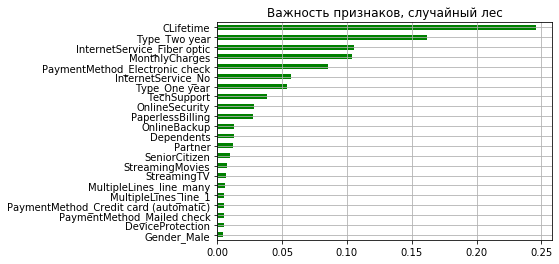

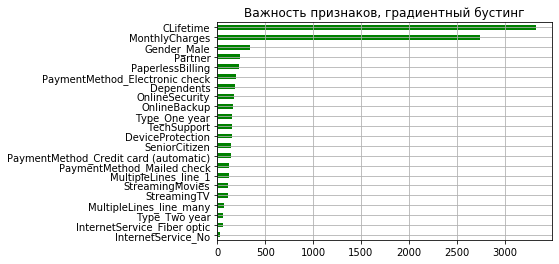

In [77]:
for model_name, model in {'случайный лес': rf, 'градиентный бустинг': lbgm}.items():

    # создание Series с признаками и сортировка
    importances_rf = pd.Series(model.feature_importances_, index=X_train_1.columns).sort_values()
    # построение графика
    importances_rf.plot(kind='barh', color='green')
    plt.title(f'Важность признаков, {model_name}')
    plt.grid(); plt.show()

- Для двух моделей важность признаков немного различается, однако заметно, что большое значение имеет именно **CLifetime** - признак, который мы создали из дат подключения и завершения контракта.
- Также в обоих случаях довольно высоко располагается **MonthlyCharges** - для *случайного леса* признак располагается на 4 месте, а для *градиентного бустинга* - на 2 месте с заметным отрывом от следующего признака.

Для занесения результатов создадим таблицу:

In [78]:
model_info = pd.DataFrame({
    'model_name':
    ['logistic regression', 'random forest', 'gradient boosting'],
    'params': [lr_list[1].best_params_, rf_list[1].best_params_, lbgm_list[1].best_params_],
    'time': ['1 s', '1 s', '1 s'],
    'accuracy_test': [lr_accuracy, rf_accuracy, lbgm_accuracy],
    'roc_auc_test': [lr_roc_auc, rf_roc_auc, lbgm_roc_auc]    
})
model_info.set_index('model_name', inplace=True)
model_info

,params,time,accuracy_test,roc_auc_test
model_name,,,,
logistic regression,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",1 s,0.802177,0.849035
random forest,"{'n_estimators': 150, 'min_samples_leaf': 0.00...",1 s,0.762423,0.855675
gradient boosting,"{'n_estimators': 300, 'min_child_weight': 0.01...",1 s,0.850923,0.909994


### 3.2. Вывод
- В качестве выборки для финального тестироания была выбрана выборка **без признака TotalCharges**.
- Все модели обучились примерно за одно время.
- Лучший результат продемонстрировала модель **градиентного бустинга**: значение **ROC-AUC** - **0.90**, значение **accuracy** - **0.85**.

# Шаг 3. Вывод

- В начале данного этапа мы рассчитали **accuracy** и **ROC-AUC** для константной модели, чтобы понимать ориентиры, хуже которых модель считалась бы непригодной.
- Далее мы проанализировали несколько моделей и проверили их на нескольких выборках.

### 3.1. Вывод   
- Для *логистической регрессии* и *случайного леса* наилучший результат получился на **выборке со всеми признаками**; для *градиентного бустинга* - на **выборке без признака TotalCharges**.
- На всех трёх выборках несколько **хуже** получился результат на датасете **без признака CLifetime**.
- Поскольку для двух первых выборок результаты довольно похожи, можем остановиться на варианте **выборки без TotalCharges** - мы сократим количество признаков (что может помочь при обучении больших выборок) и не очень сильно потеряем в значении метрики.
    
### 3.2. Вывод
- В качестве выборки для финального тестироания была выбрана выборка **без признака TotalCharges**.
- Все модели обучились примерно за одно время.
- Лучший результат продемонстрировала модель **градиентного бустинга**: значение **ROC-AUC** - **0.90**, значение **accuracy** - **0.85**.

# Шаг 4. Сравнение моделей, выбор итоговой модели

Мы рассчитали необходимую метрику **AUC-ROC** для каждой модели. Для наглядности построим все моддели на графике.  
Для этого поспользуемся функцией:

In [79]:
def roc_auc_plot(model_dict, features_test=X_test_1, target_test=y_test):    
    """Функция выводит значения ROC-AUC, accuracy и ROC-кривые моделей на одном графике:
    - model_dict - словарь c наименованием модели и самой моделью;
    - features_test - значение features тестовой выборки;
    - target_test - значение target тестовой выборки."""
    
    # построение графика TPR, FPR
    plt.figure(figsize=(8,6))
    
    # ROC-кривая случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--', label='случайная модель') 
    
    # цикл для моделей
    for model_name, model in model_dict.items():

        predictions_test = model.predict(features_test) # предсказания
        probabilities_one_test = model.predict_proba(features_test)[:, 1] # вычисление вероятностей
        fpr_model, tpr_model, thresholds_model = roc_curve(target_test, probabilities_one_test) # значения TPR, FPR, порогов
        
        print(f'Значение метрики AUC-ROC ({model_name}):', roc_auc_score(target_test, probabilities_one_test))
        print(f'Значение метрики accuracy ({model_name}):', accuracy_score(target_test, predictions_test))
        print()
             
        # ROC-кривая для выбранной модели         
        plt.plot(fpr_model, tpr_model, label=model_name)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xticks([i*0.1 for i in range(10)])
        
    plt.title('ROC-кривая')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend()
    plt.grid()
    plt.show()

Значение метрики AUC-ROC (логистическая регрессия): 0.8490346766216919
Значение метрики accuracy (логистическая регрессия): 0.8021769995267393

Значение метрики AUC-ROC (случайный лес): 0.8556753914544266
Значение метрики accuracy (случайный лес): 0.7624230951254141

Значение метрики AUC-ROC (градиентный бустинг): 0.9099939492856362
Значение метрики accuracy (градиентный бустинг): 0.8509228584950308



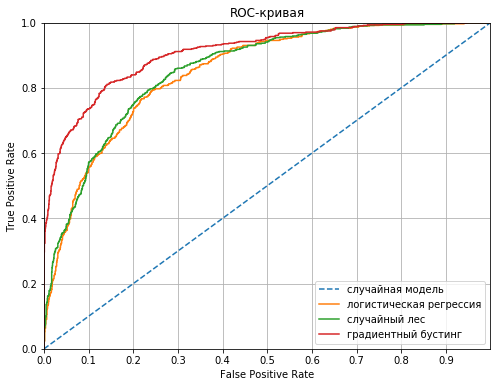

In [80]:
# выбранные модели
model_dict = roc_auc_plot({'логистическая регрессия': lr, 'случайный лес': rf, 'градиентный бустинг': lbgm})

# Шаг 4. Вывод

- При разных порогах модель **градиентного бустинга** справляется с задачей **лучше**, чем логистическая регрессия и случайный лес.
- На тестовой выборке результат **градиентного бустинга**: **ROC-ACU** порядка **0.9**, **accuracy** - **0.85**.
- Недостатки модели связаны с тем, что она требует несколько **больше** времени. Хотя при текущей выборке это было не очень заметно.

In [81]:
# вывод финальной информации
model_info

,params,time,accuracy_test,roc_auc_test
model_name,,,,
logistic regression,"{'solver': 'liblinear', 'penalty': 'l1', 'clas...",1 s,0.802177,0.849035
random forest,"{'n_estimators': 150, 'min_samples_leaf': 0.00...",1 s,0.762423,0.855675
gradient boosting,"{'n_estimators': 300, 'min_child_weight': 0.01...",1 s,0.850923,0.909994


   - В силу мультиколлинеарности, из финального датасета можно **удалить** признак **TotalCharges** и оставить только **CLifetime**.
- Таким образом, в данной задаче можно остановиться на модели **градиентного бустинга** в гиперпараметрами *{'n_estimators': 300, 'min_child_weight': 0.01, 'learning_rate': 0.1, 'class_weight': 'balanced'}*. 

# Шаг 5. Заключение (отчёт по решению)

## Отчёт о проделанной работе

### Выделение шагов в решении задачи
В процессе выполнения проекта были выделены следующие **шаги**:  
  1. Предобработка и исследовательский анализ данных.
  2. Подготовка данных для дальнейшего обучения.
  3. Обучение и тестирование выбранных моделей.
  4. Сравнение результатов, выбор лучшей модели по соотношению *метрика - время обучения*.
  
  
### Выполнение намеченного плана
После предобработки и исследовательского анализа был создан **План действий**.  
Были выполнены все пункты из **Плана действий**:
 - Проведено выделение **признака** и **целевого признака (Exited)**.
 - Выборка разделена на **обучающую** и **тестовую** в пропорции 70:30.
 - Проведено **кодирование** данных и **масштабирование** количественных признаков.
 - С помощью *RandomizedSearchCV* проведен подбор параметров моделей для финального тестирования.
 - Выбрана финальная модель с учётом соотношения *метрика - время обучения*.

### Итоговый результат
- Лучший результат продемонстрировал **градиентный бустинг** (библиотека *lightgbm*).
- Гиперпараметры модели: *'n_estimators': 300, 'min_child_weight': 0.01, 'learning_rate': 0.1, 'class_weight': 'balanced'*.
- Время обучения модели на тестовой выборке (2113 наблюдений): меньше 1 секунды.
- Результаты на тестовой выборке: **ROC-AUC** - **0.90**, **accuracy** - **0.85**.
 
 
### Трудности в решении задачи
К трудностям в решении задачи можно отнести следующее:

##### Обработка временных признаков
- **Описание проблемы**
  - В данных присутствовало два временных признака: *BeginDate* (дата заключения контракта) и *EndDate* (дата расторжения контракта).
  - Потенциальная трудность заключалась в том, чтобы сконцентрироватся не на выделении временных признаков, а на **применении их для расчёта** более логичных с точки зрения задачи показателей.
- **Решение проблемы**
  - На практике более полезным оказался не поиск сезонности, а расчёт признака *CLifetime* (время использования услуг клиентом). При анализе важности признаков моделей *CLifetime* находилось на 1-ом месте.

##### Мультиколлинеарность признаков
- **Описание проблемы**
  - Во время исследовательского анализа обнаружена **мультиколлинеарность** количественных признаков.
  - Удаление признаков может положительно сказаться на производительности и устойчивости модели, однако может снизить значение метрики.
- **Решение проблемы**
  - Чтобы избежать значительного снижения, обучение было проведено **на нескольких наборах** признаков.
  - Из финального набора был исключён признак *TotalCharges* (сумма платёжа за всё время использования услуг). Данный признак заметно коррелировал с *CLifetime* (время использования услуг клиентом).
  - В результате удаления признака *TotalCharges* значения метрик остались на приемлемом уровне.